# Comparison of Different Approximations for Transmon Readout

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

import qutip

%matplotlib inline

save_figures = True
save_path    = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Dispersive_Simulations"


In [2]:
# Meta params for plots
resolution = 126

scan_range = (5.90, 6.15)


simulation_steps = 2001

# Setup Qubit, Resonator and Coupling
n_cutoff    = 15
EJ          = 15     * 2 * np.pi # h GHz
EC          = EJ / 25

resonator_states        = 20
resonator_frequency     = 6.02 * 2 * np.pi    

coupling_strength       = 0.250 * 2 * np.pi


# Setup drive
drive_amplitude        = 0.020
driving_time           = (0, 40)
drive_function         = lambda t, args: drive_amplitude * np.cos(args["driving_frequency"] * t)

driving_frequencies_to_scan = 2 * np.pi * np.linspace(*scan_range, resolution)

# Define Qubit object
import components as comp
qubit = comp.Transmon(
    EC = EC,
    EJ = EJ,
    basis = "charge",
    n_cutoff = n_cutoff
)
# Define resonator operators
from qutip import destroy
a       = destroy(resonator_states)
a_dag   = a.dag()

In [3]:
### Tools for plotting
def plot_curves_from_result_dictionairy(dict_with_results, ax):
    
    for i, results in dict_with_results.items():
        last_states_in_resonator = [result.states[-1].ptrace(1) for result in results]
        expectation_value_of_occupation = qutip.expect(a_dag * a, last_states_in_resonator)
        ax.plot(driving_frequencies_to_scan / (2 * np.pi), expectation_value_of_occupation, label = f"$|{i}\\rangle$")
    
    ax

    return ax

In [4]:
qubit_states = 3

# Get Qubit operators for the two level qubit
H_qubit, jump_matrix = qubit.lowest_k_eigenstates(k = qubit_states)

In [37]:
# print(H_qubit.diag() - H_qubit.diag()[0] )/ abs(H_qubit.diag()[0] - H_qubit.diag()[1])
print(H_qubit.diag()[1] - H_qubit.diag()[0])
print(resonator_frequency)

49.219779357106106
37.82477554922111


In [6]:
print(H_qubit.diag()[2] - H_qubit.diag()[1])

44.29910919875201


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

### Simulation for the RWA Jaynes-Cumming model
Non interacting:  
$H_0 = \omega_r a^\dagger a + \sum_k \omega_k \ket{k}\bra{k}$  

Interacting:  
$H_1 = \sum_{i} g_{i, i+1} \ket{i}\bra{i+1}a^\dagger + g_{i-1, i}\ket{i-1}\bra{i} a$

Driving:  
$H_d = 2i  \epsilon_d \cos(\omega_d t) (a^\dagger - a)$

In [38]:
from qutip import tensor, basis
from tqdm import tqdm

### The full Hamiltonian consists of:
# H0 - simple, non interacting terms
H_0 = tensor(H_qubit, qutip.qeye(resonator_states)) + tensor(qutip.qeye(qubit_states), resonator_frequency * a_dag * a)

# H1 - coupling between qubit and resonator - Jaynes Cumming
sigma_minus = qutip.Qobj(np.diag(np.diag(jump_matrix, k = 1), k = 1))
sigma_plus = sigma_minus.dag()

H_1 = coupling_strength * (tensor(sigma_minus, a_dag) + tensor(sigma_plus, a))

# H2 - Driving of the resonator
H_d_matrix = 2j * tensor(qutip.qeye(qubit_states), a_dag - a)
H_d        = [H_d_matrix, drive_function] 

### The intitial states to consider
initial_states = [basis([qubit_states, resonator_states], [i, 0]) for i in range(qubit_states)]


### Setup for simulations
# Frequencies to try:
driving_frequencies_to_scan = 2 * np.pi * np.linspace(*scan_range, resolution)

# Dictionairy to store results
dict_for_results = {i: [] for i in range(qubit_states)}


### Do the simulations
from qutip import mesolve
for driving_frequency in tqdm(driving_frequencies_to_scan):
    for i, initial_state in enumerate(initial_states): 
        current_result = mesolve(
            [H_0, H_1, H_d],
            args = {"driving_frequency": driving_frequency},
            rho0 = initial_state,
            tlist = np.linspace(*driving_time, simulation_steps),
        )
        
        # Append results
        dict_for_results[i].append(current_result)


100%|██████████| 126/126 [14:04<00:00,  6.70s/it]


Plotting the results. We're interested in the occupation of the resonator af driving it. We plot it from the following along with lines showing the expected dispersive shift. 

In [39]:
# Multi qubit shifts
g_squared_matrix = coupling_strength ** 2 * abs(jump_matrix.full()) ** 2
omega_ij_matrix = np.expand_dims(H_qubit.diag(), 1) - np.expand_dims(H_qubit.diag(), 0)
omega_r = resonator_frequency

# The Chi-matrix
chi_matrix = g_squared_matrix * (1 / (omega_ij_matrix - omega_r) + 1 / (omega_ij_matrix + omega_r)) 

# The dis
dispersive_shifts = chi_matrix.sum(axis = 1) / 2 / np.pi

In [40]:
dispersive_shifts

array([-0.03175747, -0.06443426,  0.09619173])

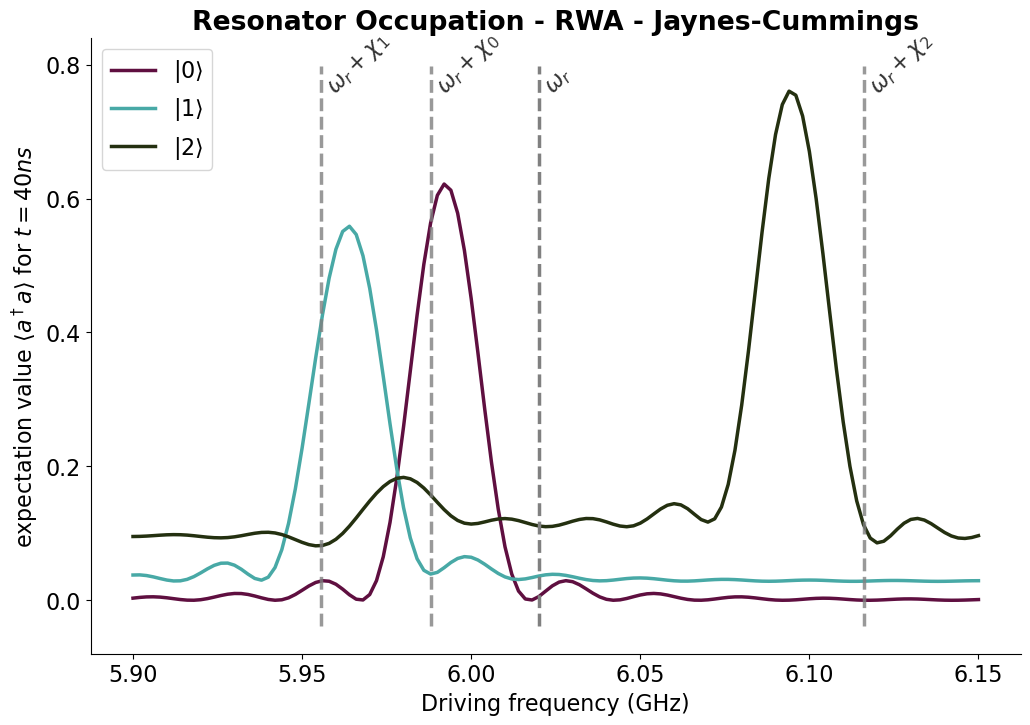

In [41]:
# Setup plot
fig, ax = plt.subplots()
ax = plot_curves_from_result_dictionairy(dict_for_results, ax)

# Plot different lines for considerations
limits = ax.get_ylim()

# dispersive_shift_approx = coupling_strength**2 * abs(jump_matrix[0, 1]) ** 2/ (resonator_frequency - H_qubit[1, 1] + H_qubit[0, 0])

omega_r = resonator_frequency / (2 * np.pi)

ax.vlines(omega_r, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r + .0005, limits[1] * 0.95, "$\omega_r$", alpha = 0.8, rotation = 45)

ax.vlines(omega_r + dispersive_shifts, *limits, linestyle = "dashed", color = "gray", alpha = 0.8)
for i, shift in enumerate(dispersive_shifts):
    ax.text(omega_r + shift + .0005, limits[1] * 0.95, f"$\omega_r + \chi_{i}$", alpha = 0.8, rotation = 45)


# Write text on it
ax.legend(loc = "upper left")
ax.set(
    title = "Resonator Occupation - RWA - Jaynes-Cummings",
    xlabel = "Driving frequency (GHz)",
    ylabel = f"expectation value $\\langle a^\\dagger a \\rangle$ for $t = {driving_time[1]} ns$"
);

if save_figures:
    fig.savefig(save_path + f"{qubit_states}State_RWA.pdf")

In [42]:
xvec = yvec = np.linspace(-5, 5, 100)
qfunc = qutip.QFunc(xvec, yvec)

def plot_time_evolution(state = 0, frequency_idx = 0, time = 0):
    fig, ax = plt.subplots(figsize = (15, 5), ncols = 2)
    reso_states = [state.ptrace(1) for state in dict_for_results[state][frequency_idx].states]
    occupation  = [qutip.expect(a_dag * a, state) for state in reso_states]
    ax[0].set_title("Resonator with qubit state $|\\psi_{}\\rangle$ at driving {:.2f} GHz".format(state, driving_frequencies_to_scan[frequency_idx] / 2 / np.pi), fontsize = 14)
    ax[0].plot(occupation, c = f"C{state}")
    ax[0].vlines(time, *ax[0].get_ylim(), linestyles = "dashed", color = "gray")
    # return reso_states


    ax[1].imshow(qfunc(reso_states[time]), extent = [xvec[0], xvec[-1], yvec[0], yvec[-1]], cmap = "Blues")
    # ax[1].vlines()
    


    fig.tight_layout()

from ipywidgets import interact

interact(plot_time_evolution, state = (0, qubit_states - 1), frequency_idx = (0, resolution - 1), time = (0, simulation_steps - 1, 10))

interactive(children=(IntSlider(value=0, description='state', max=2), IntSlider(value=0, description='frequenc…

<function __main__.plot_time_evolution(state=0, frequency_idx=0, time=0)>

### Simulation for the Dispersive Limit Hamiltonian
Non interacting:  

$H_{eff} = (\omega_r - \omega_d  + \sum_k \chi_k \ket{k}\ket{k} ) a^\dagger a$

Driving

$H_{d, eff} = \epsilon (a^\dagger + a)$

In [7]:
from qutip import tensor, basis
from tqdm import tqdm

# Multi qubit shifts
g_squared_matrix = coupling_strength ** 2 * abs(jump_matrix.full()) ** 2
omega_ij_matrix = np.expand_dims(H_qubit.diag(), 1) - np.expand_dims(H_qubit.diag(), 0)
omega_r = resonator_frequency

# The Chi-matrix
chi_matrix = g_squared_matrix * (1 / (omega_ij_matrix - omega_r) + 1 / (omega_ij_matrix + omega_r)) 

# The dispersive shifts
dispersive_shifts = chi_matrix.sum(axis = 1) # / 2 / np.pi


# We can now define the Hamiltonian:
def get_Hamiltonian(drive_frequency):
    H_res   = (omega_r - drive_frequency) * tensor(qutip.qeye(qubit_states), a_dag * a)

    H_disp  = tensor(qutip.Qobj(np.diag(dispersive_shifts)), a_dag * a)

    H_drive = drive_amplitude * tensor(qutip.qeye(qubit_states), a_dag + a)

    return H_res + H_disp + H_drive


### The intitial states to consider
initial_states = [basis([qubit_states, resonator_states], [i, 0]) for i in range(qubit_states)]


### Setup for simulations
# Frequencies to try:
driving_frequencies_to_scan = 2 * np.pi * np.linspace(*scan_range, resolution)

# Dictionairy to store results
dict_for_results = {i: [] for i in range(qubit_states)}


### Do the simulations
from qutip import mesolve
for driving_frequency in tqdm(driving_frequencies_to_scan):
    for i, initial_state in enumerate(initial_states): 
        current_result = mesolve(
            [get_Hamiltonian(driving_frequency)],
            args = {"driving_frequency": driving_frequency},
            rho0 = initial_state,
            tlist = np.linspace(*driving_time, simulation_steps),
        )
        
        # Append results
        dict_for_results[i].append(current_result)


100%|██████████| 126/126 [00:44<00:00,  2.81it/s]


Plotting the results. We're interested in the occupation of the resonator af driving it. We plot it from the following along with lines showing the expected dispersive shift. 

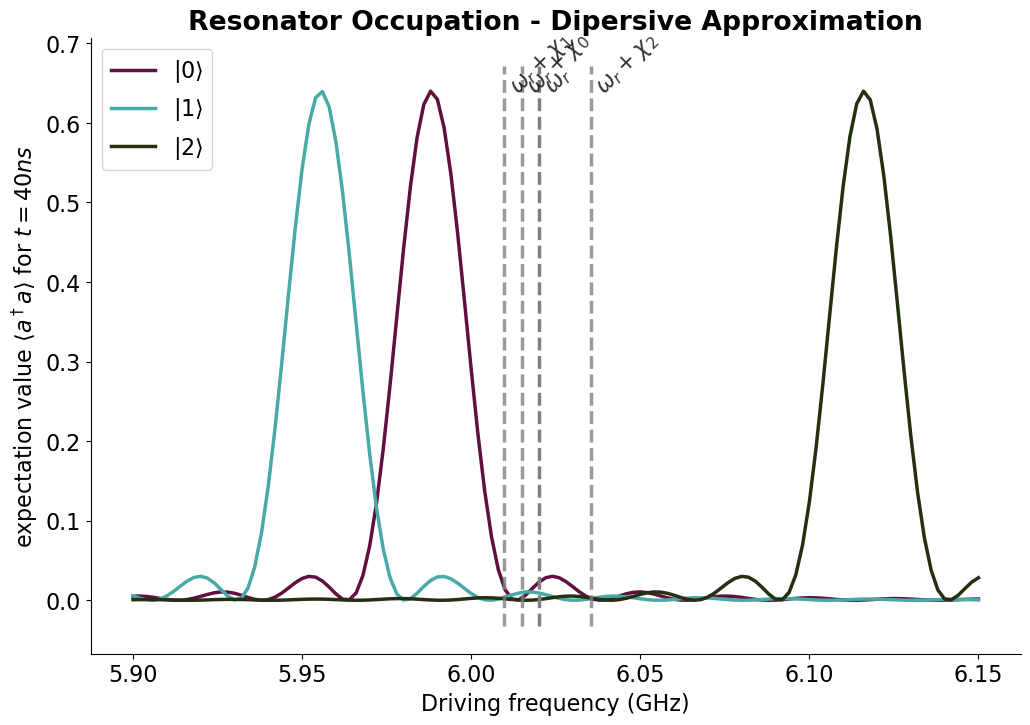

In [10]:
# Setup plot
fig, ax = plt.subplots()
ax = plot_curves_from_result_dictionairy(dict_for_results, ax)

# Plot different lines for considerations
limits = ax.get_ylim()

# dispersive_shift_ap*prox = coupling_strength**2 * abs(jump_matrix[0, 1]) ** 2/ (resonator_frequency - H_qubit[1, 1] + H_qubit[0, 0])

omega_r = resonator_frequency / (2 * np.pi)

ax.vlines(omega_r, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r + .0005, limits[1] * 0.95, "$\omega_r$", alpha = 0.8, rotation = 45)

dispersive_shifts *= 1 / (2 * np.pi)

ax.vlines(omega_r + dispersive_shifts, *limits, linestyle = "dashed", color = "gray", alpha = 0.8)
for i, shift in enumerate(dispersive_shifts):
    ax.text(omega_r + shift + .0005, limits[1] * 0.95, f"$\omega_r + \chi_{i}$", alpha = 0.8, rotation = 45)


# Write text on it
ax.legend(loc = "upper left")
ax.set(
    title = "Resonator Occupation - Dipersive Approximation",
    xlabel = "Driving frequency (GHz)",
    ylabel = f"expectation value $\\langle a^\\dagger a \\rangle$ for $t = {driving_time[1]} ns$"
);

if save_figures:
    fig.savefig(save_path + f"{qubit_states}State_Dispersive.pdf")

In [11]:
xvec = yvec = np.linspace(-5, 5, 100)
qfunc = qutip.QFunc(xvec, yvec)

def plot_time_evolution(state = 0, frequency_idx = 0, time = 0):
    fig, ax = plt.subplots(figsize = (15, 5), ncols = 2)
    reso_states = [state.ptrace(1) for state in dict_for_results[state][frequency_idx].states]
    occupation  = [qutip.expect(a_dag * a, state) for state in reso_states]
    ax[0].set_title("Resonator with qubit state $|\\psi_{}\\rangle$ at driving {:.2f} GHz".format(state, driving_frequencies_to_scan[frequency_idx] / 2 / np.pi), fontsize = 14)
    ax[0].plot(occupation, c = f"C{state}")
    ax[0].vlines(time, *ax[0].get_ylim(), linestyles = "dashed", color = "gray")
    # return reso_states


    ax[1].imshow(qfunc(reso_states[time]), extent = [xvec[0], xvec[-1], yvec[0], yvec[-1]], cmap = "Blues")
    # ax[1].vlines()
    


    fig.tight_layout()

from ipywidgets import interact

interact(plot_time_evolution, state = (0, qubit_states - 1), frequency_idx = (0, resolution - 1), time = (0, simulation_steps - 1, 10))

interactive(children=(IntSlider(value=0, description='state', max=2), IntSlider(value=0, description='frequenc…

<function __main__.plot_time_evolution(state=0, frequency_idx=0, time=0)>

### Simulation for the Full Hamiltonian
Non interacting:  
$H_0 = \omega_r a^\dagger a + \sum_k \omega_k \ket{k}\bra{k}$  

Interacting:  
$H_1 = \sum_{ij} g_{ij} \ket{i}\bra{j}(a + a^\dagger)$

Driving:  
$H_d = 2i  \epsilon_d \cos(\omega_d t) (a^\dagger - a)$

In [46]:
from qutip import tensor, basis
from tqdm import tqdm

### The full Hamiltonian consists of:
# H0 - simple, non interacting terms
H_0 = tensor(H_qubit, qutip.qeye(resonator_states)) + tensor(qutip.qeye(qubit_states), resonator_frequency * a_dag * a)

# H1 - coupling between qubit and resonator - Jaynes Cumming
H_1 = coupling_strength * tensor(jump_matrix, a_dag + a)

# H2 - Driving of the resonator
H_d_matrix = 2j * tensor(qutip.qeye(qubit_states), a_dag - a)
H_d        = [H_d_matrix, drive_function] 

### The intitial states to consider
initial_states = [basis([qubit_states, resonator_states], [i, 0]) for i in range(qubit_states)]


### Setup for simulations
# Frequencies to try:
driving_frequencies_to_scan = 2 * np.pi * np.linspace(*scan_range, resolution)

# Dictionairy to store results
dict_for_results = {i: [] for i in range(qubit_states)}


### Do the simulations
from qutip import mesolve
for driving_frequency in tqdm(driving_frequencies_to_scan):
    for i, initial_state in enumerate(initial_states): 
        current_result = mesolve(
            [H_0, H_1, H_d],
            args = {"driving_frequency": driving_frequency},
            rho0 = initial_state,
            tlist = np.linspace(*driving_time, simulation_steps),
        )
        
        # Append results
        dict_for_results[i].append(current_result)


100%|██████████| 126/126 [18:41<00:00,  8.90s/it]


Plotting the results. We're interested in the occupation of the resonator af driving it. We plot it from the following along with lines showing the expected dispersive shift. 

In [47]:
# Multi qubit shifts
g_squared_matrix = coupling_strength ** 2 * abs(jump_matrix.full()) ** 2
omega_ij_matrix = np.expand_dims(H_qubit.diag(), 1) - np.expand_dims(H_qubit.diag(), 0)
omega_r = resonator_frequency

# The Chi-matrix
chi_matrix = g_squared_matrix * (1 / (omega_ij_matrix -omega_r) + 1 / (omega_ij_matrix + omega_r)) 

# The dis
dispersive_shifts = chi_matrix.sum(axis = 1) / 2 / np.pi

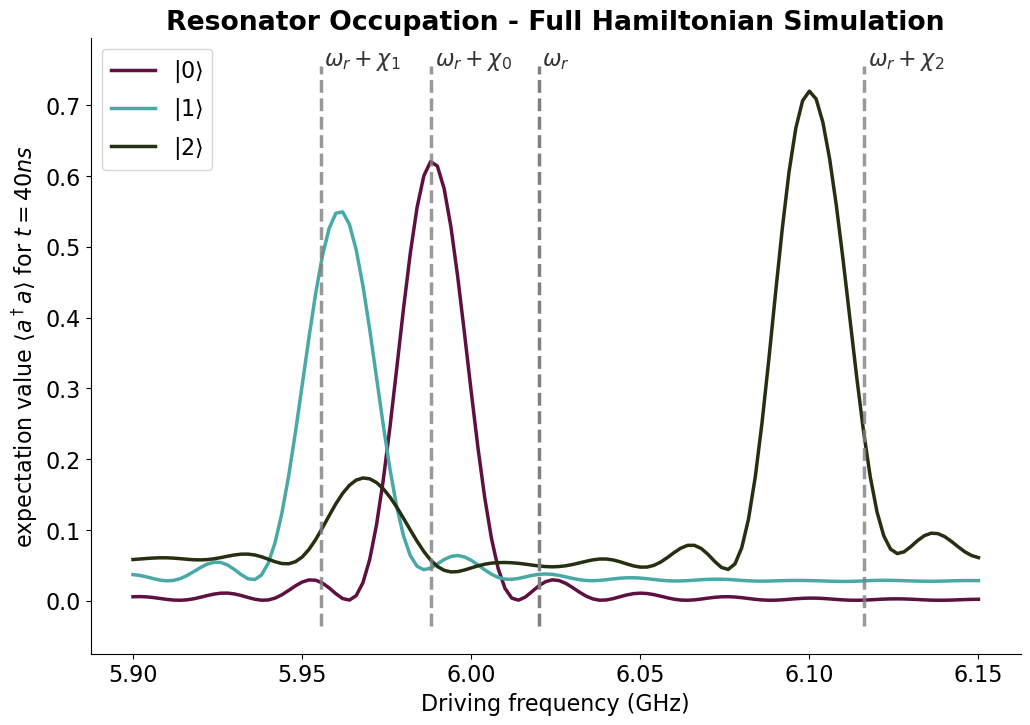

In [48]:
# Setup plot
fig, ax = plt.subplots()
ax = plot_curves_from_result_dictionairy(dict_for_results, ax)

# Plot different lines for considerations
limits = ax.get_ylim()

# dispersive_shift_approx = coupling_strength**2 * abs(jump_matrix[0, 1]) ** 2/ (resonator_frequency - H_qubit[1, 1] + H_qubit[0, 0])

omega_r = resonator_frequency / (2 * np.pi)

ax.vlines(omega_r, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r + .001, limits[1], "$\omega_r$", alpha = 0.8)

ax.vlines(omega_r + dispersive_shifts, *limits, linestyle = "dashed", color = "gray", alpha = 0.8)
for i, shift in enumerate(dispersive_shifts):
    ax.text(omega_r + shift + .001, limits[1], f"$\omega_r + \chi_{i}$", alpha = 0.8)


# Write text on it
ax.legend(loc = "upper left")
ax.set(
    title = "Resonator Occupation - Full Hamiltonian Simulation",
    xlabel = "Driving frequency (GHz)",
    ylabel = f"expectation value $\\langle a^\\dagger a \\rangle$ for $t = {driving_time[1]} ns$"
);

if save_figures:
    fig.savefig(save_path + "3State_Full.pdf")

In [49]:
xvec = yvec = np.linspace(-5, 5, 100)
qfunc = qutip.QFunc(xvec, yvec)

def plot_time_evolution(state = 0, frequency_idx = 0, time = 0):
    fig, ax = plt.subplots(figsize = (15, 5), ncols = 2)
    reso_states = [state.ptrace(1) for state in dict_for_results[state][frequency_idx].states]
    occupation  = [qutip.expect(a_dag * a, state) for state in reso_states]
    ax[0].set_title("Resonator with qubit state $|\\psi_{}\\rangle$ at driving {:.2f} GHz".format(state, driving_frequencies_to_scan[frequency_idx] / 2 / np.pi), fontsize = 14)
    ax[0].plot(occupation, c = f"C{state}")
    ax[0].vlines(time, *ax[0].get_ylim(), linestyles = "dashed", color = "gray")
    # return reso_states


    ax[1].imshow(qfunc(reso_states[time]), extent = [xvec[0], xvec[-1], yvec[0], yvec[-1]], cmap = "Blues")
    # ax[1].vlines()
    


    fig.tight_layout()

from ipywidgets import interact

interact(plot_time_evolution, state = (0, qubit_states - 1), frequency_idx = (0, resolution - 1), time = (0, simulation_steps - 1, 10))

interactive(children=(IntSlider(value=0, description='state', max=2), IntSlider(value=0, description='frequenc…

<function __main__.plot_time_evolution(state=0, frequency_idx=0, time=0)>